Introduction: This dataset name 'I'm Something of a Painter Myself' from Kaggle Competition. This dataset contain Monet paintings. I will use Variatonal Autoencoder(VAE) for this dataset in this notebook.


**Variational Autoencoder (VAE)** is a type of generative model that can learn a low-dimensional representation of input data and generate new samples from this learned representation. Unlike traditional autoencoders, VAEs use probabilistic techniques to generate these representations, which enables them to produce more diverse and realistic outputs.

VAEs work by first encoding input data into a lower-dimensional latent space, which can be thought of as a compressed representation of the input data. Then, this latent representation is decoded back into the original input space, producing a reconstructed version of the original input. During training, the VAE learns to generate this compressed representation in such a way that it can be sampled to generate new data that is similar to the original input data.

One unique feature of VAEs is that they use a variational inference technique to train the model. This involves maximizing a lower bound on the log-likelihood of the data, which allows for the use of a gradient-based optimization algorithm for efficient training.

VAEs have been successfully applied in various fields, including image and text generation, data compression, and data visualization. They have proven to be a powerful tool for unsupervised learning tasks, enabling the generation of new data without the need for paired training data.



In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nataliecheong","key":"9249518333dd4a4011b1b69118935d25"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c gan-getting-started

 99% 363M/367M [00:03<00:00, 159MB/s]
100% 367M/367M [00:03<00:00, 124MB/s]


In [ ]:
import zipfile

unz = zipfile.ZipFile('gan-getting-started.zip')

unz.extractall()

In [ ]:
import os

path = 'monet_tfrec'

if os.access(path, os.R_OK):
    print('File is readable')
else:
    print('File is not readable')
    
if os.access(path, os.W_OK):
    print('File is writable')
else:
    print('File is not writable')

File is readable
File is writable


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import warnings
warnings.filterwarnings("ignore")


**Data Preprocessing :** Data preprocessing is the process of transforming raw data into a more usable format. This step typically involves cleaning the data by removing or imputing missing values, transforming variables into a more useful format, and normalizing or scaling the data to enable better modeling. Data preprocessing can also involve feature engineering, which is the process of creating new variables or features from existing data to better capture the underlying patterns or relationships in the data.



In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=32
LATENT_DIM=100
IMAGE_SIZE=64

In [ ]:
def get_dataset_slice_paths(image_dir):
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image
     

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

***Prepraring for generate train and validation sets.***


In [ ]:
# get the list containing the image paths
paths = get_dataset_slice_paths("monet_jpg")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')
     

number of batches in the training set: 8
number of batches in the validation set: 2


**Visualizing Images**: Visualizing images is an essential task in many fields, including computer vision, image processing, and deep learning. There are various techniques for visualizing images, each of which can provide valuable insights into the content and structure of the images.Visualizing images is an essential task for gaining insights into the content and structure of images, and can provide valuable information for tasks such as image classification, object detection, and image generation. With a range of techniques and tools available, there are many options for visualizing images in a way that best suits the needs of a particular application or research question.

In [ ]:
def display_images(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(10, 10))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

     

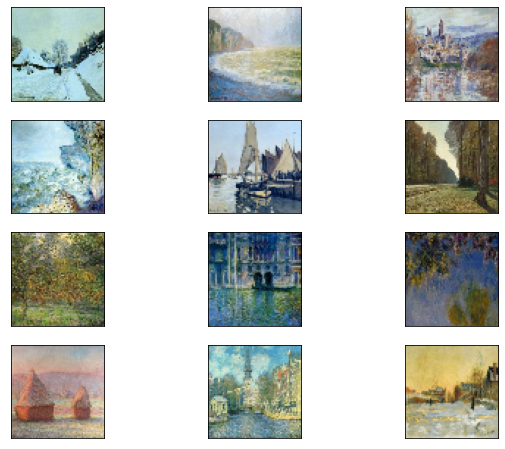

In [ ]:
display_images(validation_dataset, size=12)

**Build the model**: Building a model for Variational Autoencoder (VAE) involves several steps, including designing the architecture of sampling layer, the encoder and decoder networks, defining the loss function, and selecting appropriate optimization techniques.

**Sampling Layer**:The sampling layer is a critical component of Variational Autoencoders (VAEs) because it enables the generation of new data samples from the learned latent space. Without the sampling layer, the VAE would only be able to produce reconstructions of the input data but would not be able to generate new, diverse samples.

The sampling layer in VAEs is responsible for generating a new latent vector from a normal distribution with a mean and standard deviation that are computed from the output of the encoder network. This means that the VAE generates a new latent vector for each new sample it generates, which allows for the creation of diverse outputs.

The use of a sampling layer is necessary in VAEs because the latent space learned by the encoder network does not have a simple, well-defined structure that can be directly sampled from. Instead, the learned latent space is typically complex and nonlinear, making it difficult to generate new samples directly. The sampling layer provides a way to sample from this complex latent space, enabling the VAE to generate new, diverse samples that capture the underlying distribution of the input data.

Overall, the sampling layer is an essential component of VAEs, enabling the generation of new data samples from the learned latent space and making VAEs a powerful tool for unsupervised learning tasks.

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(sigma)[0]
    dim = tf.shape(sigma)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    
    return  z

**Encoder Layer:** The encoder layer in a Variational Autoencoder (VAE) is necessary for learning a compressed representation of the input data. The encoder network takes the input data and maps it to a lower-dimensional latent space, where each dimension represents a learned feature or attribute of the input data.

The use of an encoder layer is critical in VAEs because it enables the model to learn a compressed representation of the input data that captures the underlying distribution of the data. This compressed representation can then be used for tasks such as data compression, denoising, and generation.

One unique feature of the encoder layer in VAEs is that it uses a probabilistic approach to map the input data to the latent space. Specifically, the encoder network generates a mean and variance for each dimension of the latent space, which are used to sample from a normal distribution. This stochastic approach enables VAEs to generate diverse samples from the learned latent space, making them a powerful tool for data generation tasks.

Overall, the encoder layer is a critical component of VAEs, enabling the model to learn a compressed representation of the input data that can be used for a wide range of unsupervised learning tasks. By using a probabilistic approach to map the input data to the latent space, VAEs can generate diverse samples from the learned distribution, making them a powerful tool for data generation and analysis.






In [ ]:
def encoder_layers(inputs, latent_dim):
  # first block conv2D
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  # secomd block conv2D
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  # third block conv2D
  x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv3')(x)
  batch_3 = tf.keras.layers.BatchNormalization()(x)

  # flatten the ouput of the third conv2D
  x = tf.keras.layers.Flatten()(batch_3)
  
  # dense layer
  x = tf.keras.layers.Dense(1024, activation='relu', name='encoder_dense')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

  return mu, sigma, batch_3.shape

**Encoder Model:** The encoder model is a critical component of a Variational Autoencoder (VAE), responsible for mapping the input data to a lower-dimensional latent space. The encoder network typically consists of several layers of fully connected or convolutional neural networks that learn a compressed representation of the input data.

The architecture of the encoder model can vary depending on the specific application and data being used, but typically consists of several layers of convolutional or fully connected networks. The output of the encoder network is a set of parameters that define a probability distribution over the latent space, typically a normal distribution. These parameters are used to sample a latent vector, which is then passed to the decoder network for generating new data samples.

The training of the encoder model involves minimizing the VAE loss function, which consists of two components: the reconstruction loss and the Kullback-Leibler (KL) divergence loss. The reconstruction loss measures the difference between the input data and the output of the decoder network, while the KL divergence loss ensures that the learned latent space distribution is close to a prior distribution.

In [ ]:
def encoder_model(latent_dim, input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs=inputs, latent_dim=LATENT_DIM)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])
  model.summary()
  return model, conv_shape

**Decoder Layer**: The decoder layer in a Variational Autoencoder (VAE) is necessary for reconstructing the input data from the compressed representation learned by the encoder network. Without the decoder layer, the VAE would only be able to learn a compressed representation of the input data but would not be able to reconstruct the original data.

The decoder layer in VAEs is responsible for transforming the compressed representation (latent vector) back into the original input space. The decoder network takes the compressed representation as input and generates a reconstruction of the original data, typically with the same dimensions as the input data.

The use of a decoder layer is critical in VAEs because it enables the reconstruction of the original input data from the compressed representation, which can be used for tasks such as denoising, inpainting, and compression. Additionally, the reconstruction error between the input data and the reconstructed data can be used as a loss function during training to improve the quality of the compressed representation learned by the encoder network.

Overall, the decoder layer is an essential component of VAEs, allowing for the reconstruction of the original input data from the compressed representation learned by the encoder network. This enables VAEs to be used for a wide range of unsupervised learning tasks, making them a powerful tool for data analysis and generation.

In [ ]:
def decoder_layers(inputs, conv_shape):
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation='relu', name='decode_dense1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='decode_reshape')(x)

  # first Conv2DTranspose
  x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv2D_1')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # second Conv2DTranspose
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv2D_2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # third Conv2DTranspose
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv2D_3')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # last Conv2D transpose
  x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='decode_conv2D_final')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  return x

**Decoder Model**: The decoder model is a critical component of a Variational Autoencoder (VAE), responsible for generating new data samples from the learned compressed representation of the input data. The decoder network typically consists of several layers of fully connected or convolutional neural networks that transform the learned latent space representation into an output data format.

The architecture of the decoder model can vary depending on the specific application and data being used, but typically consists of several layers of convolutional or fully connected networks. The input to the decoder network is a latent vector generated by the encoder network, which is transformed back into the original input data space by the decoder network. Overall, the decoder model is an essential component of a VAE, enabling the model to generate new data samples from the learned compressed representation of the input data. With careful design and training, a well-designed decoder model can generate high-quality data samples that capture the underlying distribution of the input data. The decoder model plays a critical role in the success of a VAE model, enabling a wide range of unsupervised learning tasks in fields such as image and text generation, data compression, and data visualization.

In [ ]:
def decoder_model(latent_dim, conv_shape):
  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

**Loss Function:** The loss function are having the network, learn how to recontruct data that comes directly from the encoder. But the encodings in the latent space are much more complex, taking into account a random normal distribution, and having this act on what the encoder learns. For this reason,need an additional loss function. The Kullback Leibler loss function.
The Kullback-Leibler (KL) divergence is a measure of how different two probability distributions are from each other. In the context of machine learning, it is often used as a loss function in variational autoencoder (VAE) models.

In VAEs, the KL divergence loss is used to ensure that the learned latent space distribution is close to a prior distribution, typically a normal distribution. The KL divergence loss is added to the reconstruction loss in the VAE objective function, which is used to optimize the encoder and decoder networks during training.

The KL divergence loss is defined as the difference between the learned latent space distribution and the prior distribution. Specifically, it measures the amount of information lost when the learned distribution is used to approximate the prior distribution. The KL divergence loss is zero when the learned distribution is identical to the prior distribution, and it increases as the two distributions become more different.

By adding the KL divergence loss to the reconstruction loss, the VAE is encouraged to learn a compressed representation of the input data that is close to the prior distribution. This regularization term helps prevent overfitting and improves the quality of the generated data.

Overall, the KL divergence loss function is an essential component of variational autoencoders, ensuring that the learned latent space distribution is close to a prior distribution, and enabling the VAE to generate diverse and realistic data.






In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5
     

In [ ]:
def vae_model(encoder, decoder, input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu = encoder(inputs)[0]
  sigma = encoder(inputs)[1]
  z = encoder(inputs)[2]
  reconstructed = decoder(z)
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  
  return model

In [ ]:
def get_models(input_shape, latent_dim):
  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder = decoder_model(latent_dim, conv_shape)
  vae = vae_model(encoder, decoder, input_shape)
  
  return encoder, decoder, vae

In [ ]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv1 (Conv2D)         (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['encoder_conv1[0][0]']          
 alization)                                                                                       
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 16, 16, 64)   18496       ['batch_normalization[0][0]']

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()
     

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 [==============================] - 0s 135ms/step


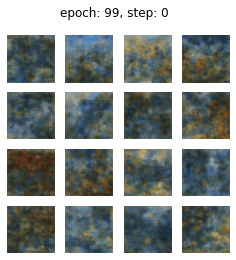

Epoch: 99 step: 0 mean loss = 169.95552
Epoch: 99 step: 1 mean loss = 169.85727
Epoch: 99 step: 2 mean loss = 169.75745
Epoch: 99 step: 3 mean loss = 169.66241
Epoch: 99 step: 4 mean loss = 169.57333
Epoch: 99 step: 5 mean loss = 169.47356
Epoch: 99 step: 6 mean loss = 169.38159
Epoch: 99 step: 7 mean loss = 169.2851


In [ ]:
epochs = 100

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 12288 # (64x64x3)
      loss += sum(vae.losses)
      
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
   
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))
     

2/2 [==============================] - 1s 307ms/step


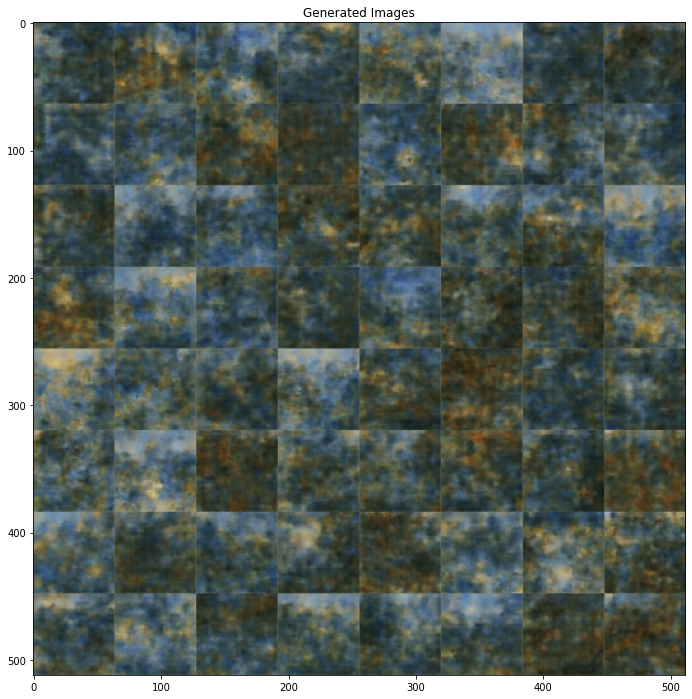

In [ ]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

**Result and Analysis:** When training the VAE, there’s not a lot of variation in the images. The above test based on how well it does in reconstructing the original images, and not how well it does in creating new images. From the above results images, the cause of the deviation could be an uneven distribution of the learned latent space. In the autoencoder model, the neural network is trained solely to compress the data into a latent space. However, there are no contraints on the distribution of the trained latent space. There might be dimension in the latent space that is much less influential than the others. If there are dimensions in the latent space that are less influential than others, it may be necessary to introduce constraints on the distribution of the latent space during training. This can be done by modifying the loss function or adding regularization techniques to encourage a more structured or uniform distribution of the learned latent variables.


**Conclusion**: Overall, after training a VAE, it is important to evaluate the performance of the model and make adjustments as needed to ensure that the learned latent space is informative and effective for downstream tasks. With careful analysis and fine-tuning, a well-designed VAE model can learn a compressed representation of input data that is highly informative and useful for a wide range of unsupervised learning tasks.

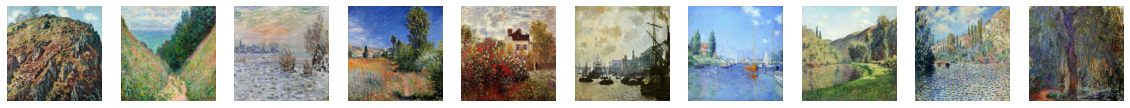

In [ ]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])
